In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import saraRC1 as sara

**Multi-Plot**

In [108]:
img_path = './Siris Dataset/ASSR/images/train/'
imgs = {}

for root, dirs, files in os.walk(img_path):
    for file in files:
        file_name = file.split('.')[0]
        imgs[file_name] = cv2.cvtColor(cv2.imread(os.path.join(root, file)), cv2.COLOR_BGR2RGB)
        break

In [109]:
mask_path = './Siris Dataset/ASSR/gt/train/'
masks = {}

for file_name in imgs:
    file = file_name + '.png'
    mask = cv2.cvtColor(cv2.imread(os.path.join(mask_path, file)), cv2.COLOR_BGR2GRAY)
    # masks[file_name] = cv2.cvtColor(cv2.imread(os.path.join(mask_path, file)), cv2.COLOR_BGR2GRAY)
    # Separate the mask based on colour
    masks[file_name] = {}

    # Detect different colours in mask
    # Create histogram
    hist = cv2.calcHist([mask], [0], None, [256], [0, 256])

    # Show non-zero values and extract intensity values at that freq
    non_zero = np.nonzero(hist)
    x = non_zero[0][1:]

    # Separate mask into regions which match the intensity values in x
    for i, intensity in enumerate(reversed(x)):
        masks[file_name][i] = np.where(mask == intensity, 1, 0)

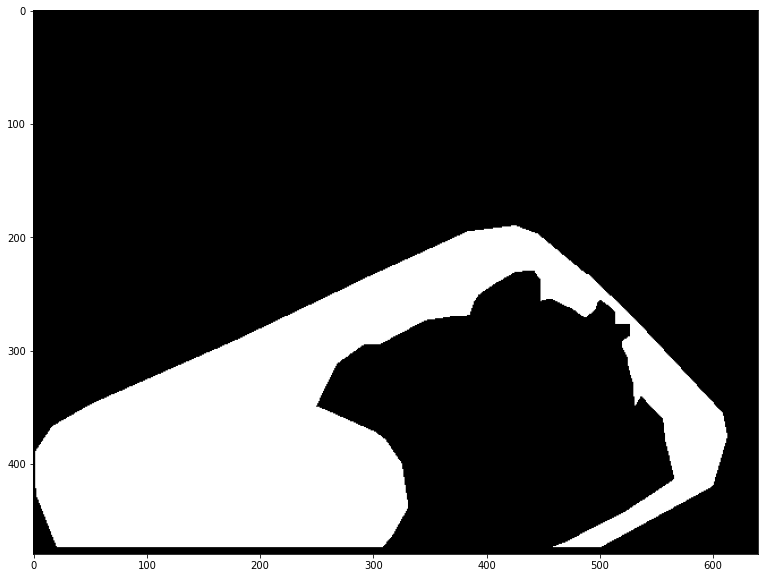

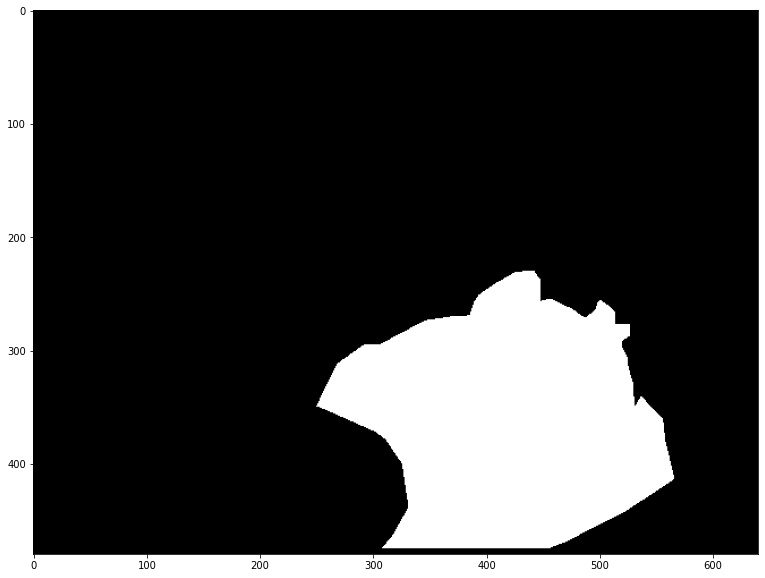

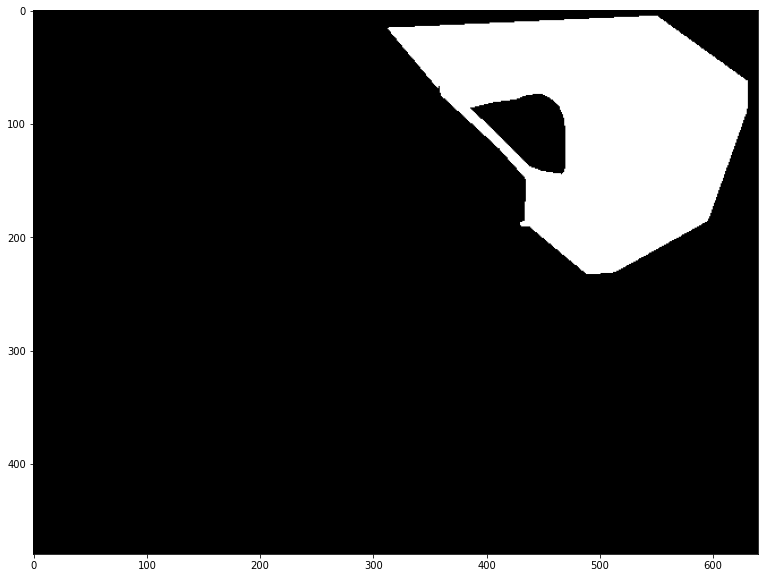

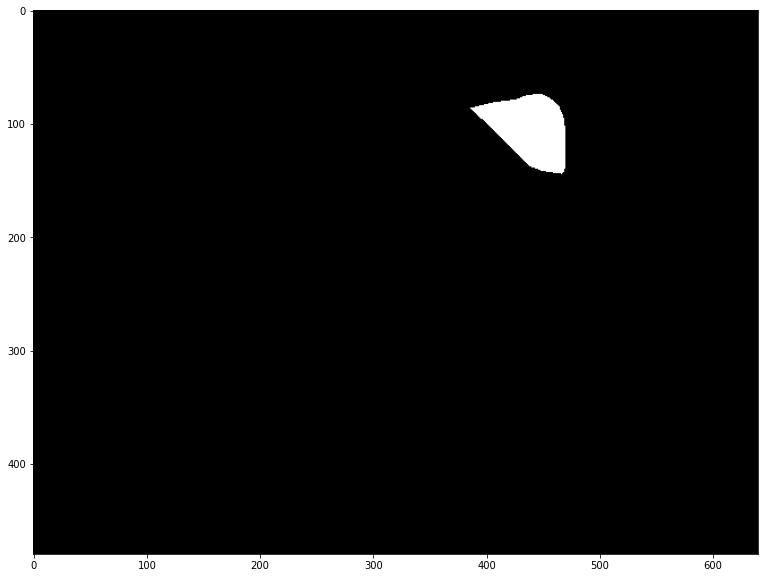

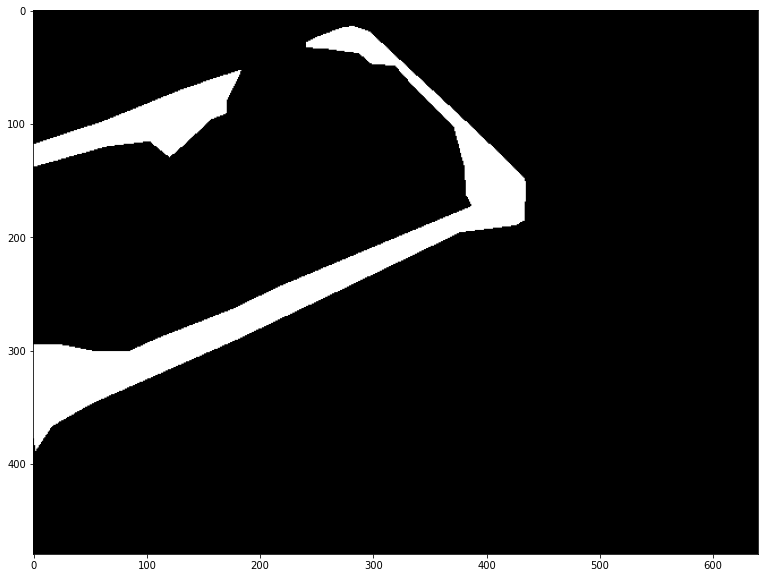

In [105]:
for mask in masks[list(masks.keys())[0]]:
    plt.imshow(masks[list(masks.keys())[0]][mask], cmap='gray')
    plt.show()

In [110]:
seg_dim = 8
saliency_maps = {}
sara_heatmaps = {}
sara_lists = {}

--> Processing image 1 of 1 (itti) [25.0%]
--> Processing image 1 of 1 (deepgaze) [50.0%]
Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\matth/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\matth/.cache\torch\hub\pytorch_vision_v0.6.0


--> Processing image 1 of 1 (fpn) [75.0%]
--> Processing image 1 of 1 (emlnet) [100.0%]
Model loaded emlnet/backbone/res_imagenet.pth
Model loaded emlnet/backbone/res_places.pth
Loaded decoder emlnet/backbone/res_decoder.pth


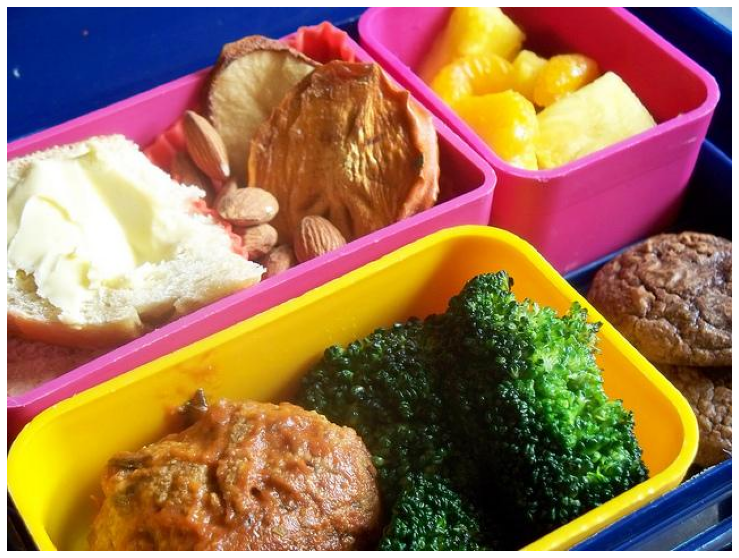

In [114]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.figure()
plt.tight_layout()

generators = ['itti', 'deepgaze', 'fpn', 'emlnet']

g = 1

for i, im in enumerate(imgs):
    if im not in saliency_maps:
        saliency_maps[im] = {}
        sara_heatmaps[im] = {}
        sara_lists[im] = {}

    for generator in generators:
        percent = round(g/(len(imgs)*len(generators))*100, 2)
        
        print(f'--> Processing image {i+1} of {len(imgs)} ({generator}) [{percent}%]')

        saliency_maps[im][generator] = sara.return_saliency(imgs[im].copy(), generator=generator)
        sara.reset()

        sara_heatmaps[im][generator], sara_lists[im][generator] = sara.return_sara(imgs[im].copy(), seg_dim, saliency_map=saliency_maps[im][generator])
        sara.reset()

        g += 1
    
    plt.subplot(1, len(imgs), i+1)
    plt.imshow(imgs[im])
    plt.axis('off')


**<h2>Mask Ranking</h2>**

In [115]:
T = 0.2

In [116]:
def index_to_coordinates(index, seg_dim, im_size):
    '''
    Given an index and a shape, this function returns the corresponding coordinates.
    '''

    x1 = int((index % seg_dim) * (im_size[1] / seg_dim))
    y1 = int((index // seg_dim) * (im_size[0] / seg_dim))

    x2 = int(x1 + (im_size[1] / seg_dim))
    y2 = int(y1 + (im_size[0] / seg_dim))
    
    return (x1, y1, x2, y2)

In [120]:
# get 2 dimensions
sara_heatmaps[sara_list]['deepgaze'].shape[0:2]

(480, 640)

In [131]:
masks[sara_list]

{0: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 1: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 2: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 3: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 4: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ...

In [132]:
# For each segment, check which mask falls under that segment using MRn = rank(Gi); (Gi interesect Mn) > T
mask_segments = {}

for sara_list in sara_lists:
    for segment in sara_lists[sara_list]['itti']:
        if sara_list not in mask_segments:
            mask_segments[sara_list] = {}

        # Convert index to coordinates, extract segment from heatmap
        shape = sara_heatmaps[sara_list]['itti'].shape[0:2]
        x1, y1, x2, y2 = index_to_coordinates(segment[5], seg_dim, shape)
        print(x1, y1, x2, y2)

        for m in masks[sara_list]:
            if m not in mask_segments[sara_list]:
                mask_segments[sara_list][m] = []

            # Extract mask from masks
            mask = masks[sara_list][m][y1:y2, x1:x2]

            # Calculate intersection over union
            intersection = np.sum(mask > 0)
            union = np.sum(mask > 0) + np.sum(mask == 0)

            iou = intersection / union

            print('Segment: ', segment[5], 'Mask: ', m, 'IoU: ', iou)

            if iou > T:
                # index, rank, saliency
                print('HERE')
                print(segment)
                mask_segments[sara_list][m].append((segment[5], segment[0], segment[1]))
                print(mask_segments)

560 420 640 480
Segment:  63 Mask:  0 IoU:  0.0925
Segment:  63 Mask:  1 IoU:  0.0
Segment:  63 Mask:  2 IoU:  0.0
Segment:  63 Mask:  3 IoU:  0.0
Segment:  63 Mask:  4 IoU:  0.0
480 420 560 480
Segment:  62 Mask:  0 IoU:  0.3258333333333333
HERE
(44, 655046914.2590985, 655046912.2864436, 0.9726549474122855, 1, 62, 4)
{'COCO_train2014_000000000009': {0: [(62, 44, 655046914.2590985)], 1: [], 2: [], 3: [], 4: []}}
Segment:  62 Mask:  1 IoU:  0.3772916666666667
HERE
(44, 655046914.2590985, 655046912.2864436, 0.9726549474122855, 1, 62, 4)
{'COCO_train2014_000000000009': {0: [(62, 44, 655046914.2590985)], 1: [(62, 44, 655046914.2590985)], 2: [], 3: [], 4: []}}
Segment:  62 Mask:  2 IoU:  0.0
Segment:  62 Mask:  3 IoU:  0.0
Segment:  62 Mask:  4 IoU:  0.0
400 420 480 480
Segment:  61 Mask:  0 IoU:  0.020416666666666666
Segment:  61 Mask:  1 IoU:  0.8914583333333334
HERE
(36, 2180542528.907711, 2180542526.907711, 1.0, 1, 61, 4)
{'COCO_train2014_000000000009': {0: [(62, 44, 655046914.2590985)]

In [137]:
# For each mask, find the segment with the lowest rank
mask_segments_min = {}

for sara_list in mask_segments:
    for m in mask_segments[sara_list]:
        # mask_segments_min[sara_list][m] = min(mask_segments[sara_list][m], key=lambda x: x[1])[0]
        if sara_list not in mask_segments_min:
            mask_segments_min[sara_list] = {}
        
        mask_segments_min[sara_list][m] = min(mask_segments[sara_list][m], key=lambda x: x[1])

mask_segments_min

{'COCO_train2014_000000000009': {0: (43, 11, 2.0186317686409994e+18),
  1: (60, 0, 173873322787.30865),
  2: (5, 6, 4.881821942767994e+48),
  3: (13, 14, 4.835562797645064e+38),
  4: (20, 5, 4.419403138953333e+31)}}

In [165]:
mask_ranks = {}

for sara_list in mask_segments_min:
    mask_ranks[sara_list] = {}
    # Extract the ranks and sort them by the third value in each tuple
    sorted_ranks = sorted(mask_segments_min[sara_list].items(), key=lambda x: x[1][1])

    for i in range(len(sorted_ranks)):
        mask_ranks[sara_list][sorted_ranks[i][0]] = i

    # Sort mask_ranks[sara_list] by object
    mask_ranks[sara_list] = {k: v for k, v in sorted(mask_ranks[sara_list].items(), key=lambda item: item[0])}

In [169]:
mask_ranks['COCO_train2014_000000000009'][1]

0

**<h2>Spearman Correlation (Metric for Ranks)</h2>**

In [5]:
import scipy.stats as sc

ranks = {}
for i in range(len(sara_lists)):
    ranks[i] = {}

    for key, value in sara_lists[i].items():
        ranks[i][key] = [i[0] for i in value]

# print(ranks)


In [50]:
len(ranks[0]['deepgaze'])

64

In [6]:
spr = sc.spearmanr(ranks[1]["itti"], ranks[1]["deepgaze"])
print(spr)

SpearmanrResult(correlation=0.2720695970695971, pvalue=0.029640211403707786)


**<h2>Normalizing Spearman Correlation</h2>**

In [7]:
def get_norm_spr(spr_value):
    #       m - r_min
    # m -> ---------------- x (t_max - t_min) + t_min
    #       r_max - r_min
    #
    # m = measure value
    # r_min = min range of measurement
    # r_max = max range of measurement
    # t_min = min range of desired scale
    # t_max = max range of desired scale

    r_min = -1
    r_max = 1

    norm_spr = (spr_value - r_min) / (r_max - r_min)

    return norm_spr

In [8]:
norm_spr = get_norm_spr(spr.correlation)
print(norm_spr)

0.6360347985347985
